In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats

In [159]:
df = pd.read_excel("Temperature in Sao Paulo.xlsx",index_col='Date',parse_dates=True, sheet_name="DJIA")
df_for_date=df[int(len(df['Realised'])*0.7):].reset_index()
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(len(test)-window_size):
    row = [[a] for a in scaled_test_input[i:i+window_size]]
    X.append(row)
    y.append(test[i+window_size])
  return np.array(X), np.array(y)

In [134]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

In [135]:
scaler = MinMaxScaler()

Best hyperparameters

Epoch: 7 | Inputs: 126 | Nodes: 126 | Dropout: 0 | Loss: mse




# H=1 Forecasts

In [160]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [166]:
for i in range(14):
  n_features = 3
  n_input = 126
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7)-n_input:]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(126, activation='tanh', input_shape=(n_input, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=7)
  X, y = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(len(y), n_input, n_features)
  y_hat=model.predict(X)
  true_predictions = scaler.inverse_transform(y_hat)
  test=test[n_input:]
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/7
109/109 [==============================] - 23s 167ms/step - loss: 0.0036 - accuracy: 2.8902e-04 - mean_absolute_error: 0.0387
Epoch 2/7
109/109 [==============================] - 19s 172ms/step - loss: 0.0026 - accuracy: 2.8902e-04 - mean_absolute_error: 0.0336
Epoch 3/7
109/109 [==============================] - 18s 161ms/step - loss: 0.0026 - accuracy: 2.8902e-04 - mean_absolute_error: 0.0332
Epoch 4/7
109/109 [==============================] - 19s 175ms/step - loss: 0.0025 - accuracy: 2.8902e-04 - mean_absolute_error: 0.0315
Epoch 5/7
109/109 [==============================] - 18s 162ms/step - loss: 0.0024 - accuracy: 2.8902e-04 - mean_absolute_error: 0.0321
Epoch 6/7
109/109 [==============================] - 19s 175ms/step - loss: 0.0023 - accuracy: 2.8902e-04 - mean_absolute_error: 0.0309
Epoch 7/7
49/49 [==============================] - 4s 68ms/step
Epoch 1/7
109/109 [==============================] - 20s 160ms/step - loss: 0.0057 - accuracy: 2.8902e-04 - mean_absolut

/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/numpy_.py:161: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [167]:
Accuracy

[67.12180047698604,
 55.691855929351355,
 66.63940800992859,
 59.11454398560363,
 68.51460452273295,
 57.98817454814387,
 64.30956647398742,
 68.15089814453424,
 61.20957318560405,
 67.08242516975645,
 64.32397261479817,
 50.63223501951503,
 65.520067670465,
 51.666250339011285,
 41.64663273356847]

In [168]:
RMSE

[0.0023513209360095572,
 0.0023963092846502813,
 0.002273065561647132,
 0.002329267161882989,
 0.0022322149943325084,
 0.0029372316003616105,
 0.002218352465629358,
 0.002360921888361216,
 0.0022732495957347985,
 0.0022235138852961175,
 0.0022425112679512324,
 0.0025256423029556435,
 0.0025734965382928528,
 0.0024992657168271116,
 0.0037457995583490217]

In [169]:
Quasilikelihood

[0.09217176595077692,
 0.12083845040632402,
 0.08669592150003336,
 0.10817184250944337,
 0.0811806106781414,
 0.21975210803271306,
 0.09013740526490169,
 0.09129010870830613,
 0.10131729657537879,
 0.08341288030981953,
 0.09172454513778877,
 0.14066415772575794,
 0.12051043699025116,
 0.13817485616134015,
 0.459271408077439]

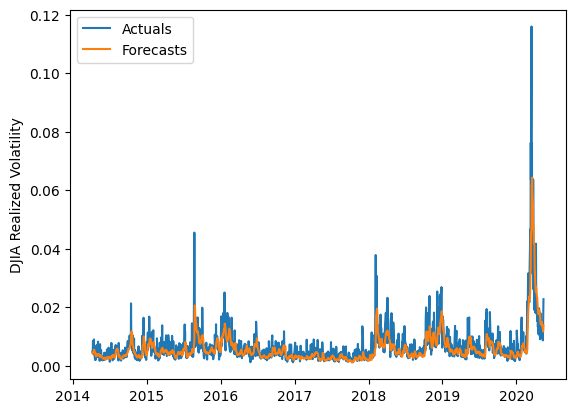

In [165]:
# Best model
plt.plot(df_for_date["Date"], test)
plt.plot(df_for_date["Date"], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

In [170]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/3)):
    row = [[a] for a in scaled_test_input[i*3:(i*3)+window_size]]
    X.append(row)
  return np.array(X)

# H=3 Forecasts

In [171]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [177]:
for i in range (14):
  n_features = 3
  n_input = 126
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(126, activation='tanh', input_shape=(n_input, n_features)))
  model.add(Dense(3))
  model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=7)
  test=test[:len(test)-1]
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/3))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/7
109/109 [==============================] - 23s 169ms/step - loss: 0.0039 - accuracy: 0.1798 - mean_absolute_error: 0.0408
Epoch 2/7
109/109 [==============================] - 18s 162ms/step - loss: 0.0027 - accuracy: 0.0986 - mean_absolute_error: 0.0328
Epoch 3/7
109/109 [==============================] - 18s 161ms/step - loss: 0.0025 - accuracy: 0.1659 - mean_absolute_error: 0.0319
Epoch 4/7
109/109 [==============================] - 18s 161ms/step - loss: 0.0025 - accuracy: 0.2488 - mean_absolute_error: 0.0320
Epoch 5/7
109/109 [==============================] - 19s 174ms/step - loss: 0.0025 - accuracy: 0.1477 - mean_absolute_error: 0.0331
Epoch 6/7
109/109 [==============================] - 18s 161ms/step - loss: 0.0026 - accuracy: 0.3188 - mean_absolute_error: 0.0326
Epoch 7/7
16/16 [==============================] - 1s 60ms/step
Epoch 1/7
109/109 [==============================] - 21s 175ms/step - loss: 0.0043 - accuracy: 0.3699 - mean_absolute_error: 0.0421
Epoch 2/7
10

In [178]:
Accuracy

[59.68264290941112,
 53.004303075737866,
 59.70459509339396,
 54.157340445572835,
 56.236926467682835,
 51.87514143222962,
 65.6676823955944,
 57.68639603319359,
 61.490562707154425,
 60.79938125484772,
 65.20742539562374,
 49.99335523224313,
 63.52836733741623,
 60.001881118541924,
 63.87006718960806]

In [179]:
RMSE

[0.0024364433986913095,
 0.002570658415721757,
 0.002479335323391368,
 0.002527775463961768,
 0.002486162674923973,
 0.002611224071728825,
 0.002457096704074853,
 0.002468765120683185,
 0.0024356446028465915,
 0.0024670885235759787,
 0.002403276794682237,
 0.002631582968331426,
 0.0024047464718847107,
 0.002429587507165989,
 0.0024110245936480247]

In [180]:
Quasilikelihood

[0.11108515595616371,
 0.13606971087448433,
 0.11287164501420614,
 0.13152488506115745,
 0.12399794780708662,
 0.14080745721808655,
 0.09772956064536382,
 0.11966635314623153,
 0.10699783365343657,
 0.11158450389284513,
 0.09627760288739375,
 0.14974320458948145,
 0.0998509830506243,
 0.10982669084417755,
 0.09990358563011205]

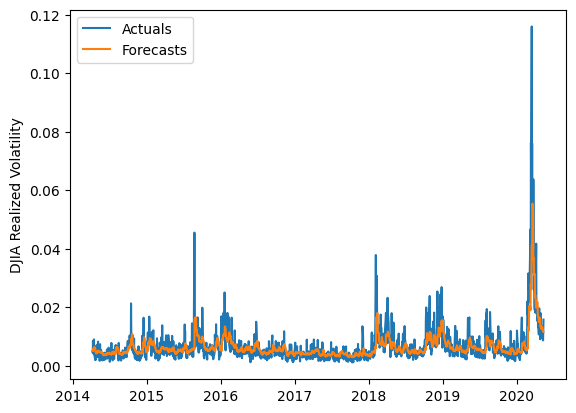

In [176]:
# Best model
plt.plot(df_for_date["Date"][:len(test)], test)
plt.plot(df_for_date["Date"][:len(test)], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

# H=5 Forecasts

In [181]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/5)):
    row = [[a] for a in scaled_test_input[i*5:(i*5)+window_size]]
    X.append(row)
  return np.array(X)

In [182]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [188]:
for i in range (14):
  n_features = 3
  n_input = 126
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(126, activation='tanh', input_shape=(n_input, n_features)))
  model.add(Dense(5))
  model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=7)
  test=test[:len(test)-2]
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/5))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/7
109/109 [==============================] - 21s 166ms/step - loss: 0.0039 - accuracy: 0.1020 - mean_absolute_error: 0.0390
Epoch 2/7
109/109 [==============================] - 17s 160ms/step - loss: 0.0029 - accuracy: 0.1711 - mean_absolute_error: 0.0346
Epoch 3/7
109/109 [==============================] - 18s 161ms/step - loss: 0.0027 - accuracy: 0.2399 - mean_absolute_error: 0.0330
Epoch 4/7
109/109 [==============================] - 19s 176ms/step - loss: 0.0026 - accuracy: 0.2156 - mean_absolute_error: 0.0323
Epoch 5/7
109/109 [==============================] - 17s 160ms/step - loss: 0.0026 - accuracy: 0.2462 - mean_absolute_error: 0.0321
Epoch 6/7
109/109 [==============================] - 19s 173ms/step - loss: 0.0024 - accuracy: 0.2711 - mean_absolute_error: 0.0311
Epoch 7/7
10/10 [==============================] - 1s 88ms/step
Epoch 1/7
109/109 [==============================] - 20s 159ms/step - loss: 0.0038 - accuracy: 0.3014 - mean_absolute_error: 0.0409
Epoch 2/7
10

In [189]:
Accuracy

[52.77227568352312,
 49.376143438063494,
 62.39309293486295,
 55.53520011235356,
 54.12370062002743,
 57.85492657086175,
 59.57934515478445,
 58.59015548067084,
 39.713745991712976,
 63.82000119031511,
 58.089857852293036,
 57.54837521303146,
 53.946740002114524,
 58.72567602990222,
 47.399159273800564]

In [190]:
RMSE

[0.002749375908226272,
 0.002691678466726813,
 0.0024787858315157584,
 0.002608196158325104,
 0.002633033059742171,
 0.0025327661302592176,
 0.0025307059667582484,
 0.0025843451017255655,
 0.0029779567408203533,
 0.002534905136627452,
 0.0025303024260090188,
 0.0025386525495700828,
 0.002583488665669672,
 0.0025274187169154966,
 0.0027532353280620234]

In [191]:
Quasilikelihood

[0.14584574069383122,
 0.15572554926233997,
 0.10748886050378727,
 0.13038024948883153,
 0.13421274248926549,
 0.1225309931808409,
 0.11578469711485662,
 0.11888897552778228,
 0.1952281771919649,
 0.10753458598911263,
 0.12091626684700918,
 0.12247427878028717,
 0.13641498383766376,
 0.11894361749862857,
 0.16270970161756423]

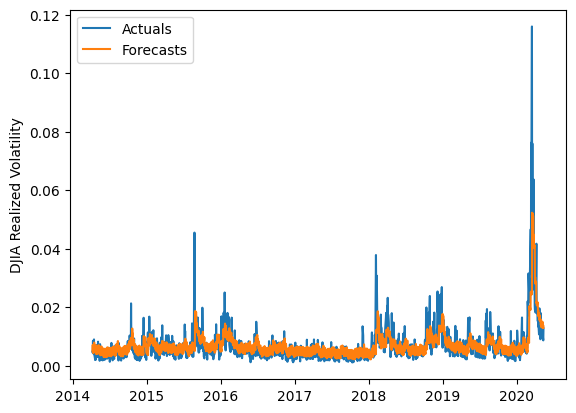

In [187]:
# Best model
plt.plot(df_for_date["Date"][:len(test)], test)
plt.plot(df_for_date["Date"][:len(test)], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

# H=10 Forecasts

In [192]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/10)):
    row = [[a] for a in scaled_test_input[i*10:(i*10)+window_size]]
    X.append(row)
  return np.array(X)

In [193]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [199]:
for i in range (14):
  n_features = 3
  n_input = 126
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(126, activation='tanh', input_shape=(n_input, n_features)))
  model.add(Dense(10))
  model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=7)
  test=test[:len(test)-7]
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/10))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/7
109/109 [==============================] - 20s 161ms/step - loss: 0.0041 - accuracy: 0.1552 - mean_absolute_error: 0.0408
Epoch 2/7
109/109 [==============================] - 19s 175ms/step - loss: 0.0028 - accuracy: 0.0951 - mean_absolute_error: 0.0334
Epoch 3/7
109/109 [==============================] - 17s 159ms/step - loss: 0.0026 - accuracy: 0.1234 - mean_absolute_error: 0.0317
Epoch 4/7
109/109 [==============================] - 19s 170ms/step - loss: 0.0026 - accuracy: 0.1769 - mean_absolute_error: 0.0320
Epoch 5/7
109/109 [==============================] - 17s 161ms/step - loss: 0.0025 - accuracy: 0.1936 - mean_absolute_error: 0.0320
Epoch 6/7
109/109 [==============================] - 19s 175ms/step - loss: 0.0025 - accuracy: 0.2971 - mean_absolute_error: 0.0319
Epoch 7/7
5/5 [==============================] - 1s 56ms/step
Epoch 1/7
109/109 [==============================] - 20s 156ms/step - loss: 0.0043 - accuracy: 0.2919 - mean_absolute_error: 0.0407
Epoch 2/7
109/

/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/numpy_.py:161: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/7
109/109 [==============================] - 19s 159ms/step - loss: 0.0038 - accuracy: 0.1231 - mean_absolute_error: 0.0390
Epoch 2/7
109/109 [==============================] - 17s 159ms/step - loss: 0.0028 - accuracy: 0.0827 - mean_absolute_error: 0.0340
Epoch 3/7
109/109 [==============================] - 18s 166ms/step - loss: 0.0028 - accuracy: 0.1006 - mean_absolute_error: 0.0341
Epoch 4/7
109/109 [==============================] - 17s 158ms/step - loss: 0.0025 - accuracy: 0.1142 - mean_absolute_error: 0.0319
Epoch 5/7
109/109 [==============================] - 18s 166ms/step - loss: 0.0025 - accuracy: 0.1009 - mean_absolute_error: 0.0325
Epoch 6/7
109/109 [==============================] - 17s 158ms/step - loss: 0.0024 - accuracy: 0.2789 - mean_absolute_error: 0.0309
Epoch 7/7
5/5 [==============================] - 1s 57ms/step
Epoch 1/7
109/109 [==============================] - 21s 164ms/step - loss: 0.0037 - accuracy: 0.0526 - mean_absolute_error: 0.0387
Epoch 2/7
109/

In [200]:
Accuracy

[39.06969910252659,
 48.6583620188668,
 53.05935111453963,
 53.298967344548466,
 57.02614311067968,
 57.445389137866535,
 60.259425460053684,
 59.3569436609939,
 56.664196742404414,
 60.16694904809019,
 46.75621171095249,
 59.22337804594547,
 57.693423863294534,
 59.94581631345402,
 59.68106829798232]

In [201]:
RMSE

[0.0030992150714497773,
 0.0028960879424690554,
 0.002770974451931914,
 0.0033907124484599946,
 0.0027719572807277304,
 0.0027525924210282746,
 0.002748379045428785,
 0.0028485541289951267,
 0.0027174582233999447,
 0.0028971032995208446,
 0.002912151120187351,
 0.0029445765535703466,
 0.00279112523930453,
 0.0027633759060637433,
 0.0027703215652729583]

In [202]:
Quasilikelihood

[0.2012552175747294,
 0.16058781660780141,
 0.1436870610113703,
 0.23363633335104125,
 0.12952060927870987,
 0.1327325635850403,
 0.1214326906934912,
 0.12823069797038097,
 0.1311705353142515,
 0.13661221503653678,
 0.16821682233866514,
 0.14633093254836746,
 0.1279559034466193,
 0.12333348128504722,
 0.12363682745514575]

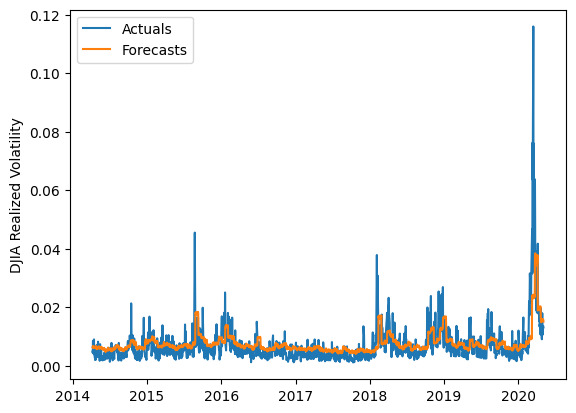

In [198]:
# Best model
plt.plot(df_for_date["Date"][:len(test)], test)
plt.plot(df_for_date["Date"][:len(test)], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

# H=22 Forecasts

In [203]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/22)):
    row = [[a] for a in scaled_test_input[i*22:(i*22)+window_size]]
    X.append(row)
  return np.array(X)

In [204]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [210]:
for i in range (14):
  n_features = 3
  n_input = 126
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(126, activation='tanh', input_shape=(n_input, n_features)))
  model.add(Dense(22))
  model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=7)
  test=test[:len(test)-19]
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/22))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/7
109/109 [==============================] - 50s 365ms/step - loss: 0.0039 - accuracy: 0.0754 - mean_absolute_error: 0.0397
Epoch 2/7
109/109 [==============================] - 23s 212ms/step - loss: 0.0028 - accuracy: 0.2561 - mean_absolute_error: 0.0336
Epoch 3/7
109/109 [==============================] - 24s 223ms/step - loss: 0.0028 - accuracy: 0.2277 - mean_absolute_error: 0.0340
Epoch 4/7
109/109 [==============================] - 25s 227ms/step - loss: 0.0025 - accuracy: 0.1399 - mean_absolute_error: 0.0314
Epoch 5/7
109/109 [==============================] - 22s 201ms/step - loss: 0.0025 - accuracy: 0.1358 - mean_absolute_error: 0.0316
Epoch 6/7
109/109 [==============================] - 21s 194ms/step - loss: 0.0025 - accuracy: 0.1731 - mean_absolute_error: 0.0317
Epoch 7/7
3/3 [==============================] - 1s 69ms/step
Epoch 1/7
109/109 [==============================] - 25s 175ms/step - loss: 0.0045 - accuracy: 0.1685 - mean_absolute_error: 0.0413
Epoch 2/7
109/

3/3 [==============================] - 1s 45ms/step
Epoch 1/7
109/109 [==============================] - 26s 210ms/step - loss: 0.0040 - accuracy: 0.0451 - mean_absolute_error: 0.0405
Epoch 2/7
109/109 [==============================] - 22s 205ms/step - loss: 0.0031 - accuracy: 0.2538 - mean_absolute_error: 0.0351
Epoch 3/7
109/109 [==============================] - 19s 172ms/step - loss: 0.0026 - accuracy: 0.3815 - mean_absolute_error: 0.0323
Epoch 4/7
109/109 [==============================] - 20s 184ms/step - loss: 0.0026 - accuracy: 0.3983 - mean_absolute_error: 0.0327
Epoch 5/7
109/109 [==============================] - 18s 167ms/step - loss: 0.0025 - accuracy: 0.1179 - mean_absolute_error: 0.0314
Epoch 6/7
109/109 [==============================] - 20s 183ms/step - loss: 0.0025 - accuracy: 0.1618 - mean_absolute_error: 0.0318
Epoch 7/7
109/109 [==============================] - 18s 163ms/step - loss: 0.0025 - accuracy: 0.1211 - mean_absolute_error: 0.0316


3/3 [==============================] - 1s 38ms/step
Epoch 1/7
109/109 [==============================] - 22s 167ms/step - loss: 0.0051 - accuracy: 5.7803e-04 - mean_absolute_error: 0.0417
Epoch 2/7
109/109 [==============================] - 19s 176ms/step - loss: 0.0028 - accuracy: 0.0197 - mean_absolute_error: 0.0330
Epoch 3/7
109/109 [==============================] - 18s 164ms/step - loss: 0.0031 - accuracy: 5.7803e-04 - mean_absolute_error: 0.0359
Epoch 4/7
109/109 [==============================] - 18s 162ms/step - loss: 0.0027 - accuracy: 0.0081 - mean_absolute_error: 0.0329
Epoch 5/7
109/109 [==============================] - 18s 163ms/step - loss: 0.0025 - accuracy: 0.0040 - mean_absolute_error: 0.0315
Epoch 6/7
109/109 [==============================] - 18s 163ms/step - loss: 0.0024 - accuracy: 0.0353 - mean_absolute_error: 0.0312
Epoch 7/7
3/3 [==============================] - 1s 42ms/step
Epoch 1/7
109/109 [==============================] - 22s 177ms/step - loss: 0.0050 - a

In [211]:
Accuracy

[57.09759804750457,
 53.13254855482996,
 51.83457493638124,
 52.23324270909791,
 47.24722072361514,
 51.23762803214065,
 37.0201049987223,
 42.19359396359417,
 48.25493821020257,
 55.61256433357036,
 42.56171111935457,
 55.879541473555726,
 33.526427673151495,
 52.51557359431833,
 40.62891677480294]

In [212]:
RMSE

[0.0031817549439318344,
 0.003109786430169596,
 0.0031187761502399296,
 0.0031847026050684786,
 0.0032897046783516037,
 0.003163496286970462,
 0.003427713500153495,
 0.0033074942965034253,
 0.003307770128873172,
 0.0033041825782007166,
 0.0034501936515653766,
 0.003044616713893913,
 0.0038079371377490083,
 0.003186753827748089,
 0.0033248580071595724]

In [213]:
Quasilikelihood

[0.15511703670923147,
 0.156548527874075,
 0.1608869492120267,
 0.16278106071475287,
 0.17857682660088234,
 0.16322761408508232,
 0.2190971343867284,
 0.1970021688266376,
 0.17790377165407636,
 0.16459915328690738,
 0.19731538885171507,
 0.1494337697548682,
 0.23815072197031564,
 0.16119960834718045,
 0.2042917939570715]

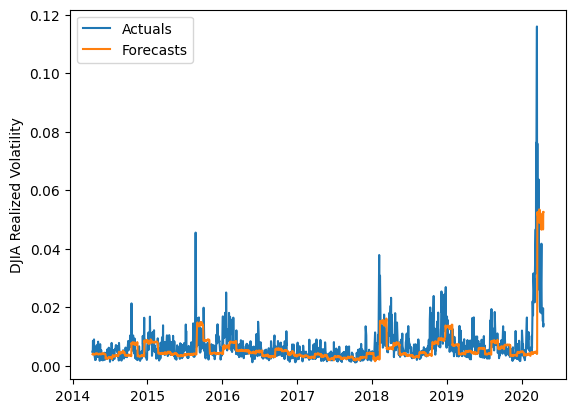

In [209]:
# Best model
plt.plot(df_for_date["Date"][:len(test)], test)
plt.plot(df_for_date["Date"][:len(test)], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])